In [1]:
#general explore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

In [2]:
#cluster imports
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [3]:
# modeling imports, you wanted to do this in a separate notebook 
# so things weren't super cluttered 
# but here we are
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, r2_score, precision_score, f1_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyRegressor, DummyClassifier

from scipy.stats import uniform, loguniform

## Modeling specific fires and surrounding AQ sensors
Aggregate model results, see if trend
Model prescribed vs wildfire separately - what are differences in AQ impact?

#### Step 1: General feature engineering
* overall_aqi = product of individual pollutant aqi_scores (based on EPA Level of Concern classes)
* square overall_aqi and smoke_score to add weight to 1-unit change
* add fire presence/absence col: fire = present (1) from ignition day _t_ to _t_+7
    * EDIT: only do this once data have been subset by REGION: otherwise you indicate Yes presence of fire in Oregon when there's a burn at the MX-AZ border
    * if time, manually pick out large fires with known containment dates and expand this window appropriately


#### Step 2: Choose Fires
* ideally events in proximity of AQ censors.  see tableau visuals to find clusters.
    * also try your own clustering: KMeans
* events with as much data as possible (filter nulls)
* start with 3x3 wild v. rx

In [4]:
motherload = pd.read_csv('../../scratch_data/merges/matched_smoke_fire_pollution_CORRECT.csv')

In [5]:
motherload.dtypes

state                       object
city                        object
county_name                 object
date                         int64
incid_type                  object
burnbndac                  float64
smoke_score                float64
no2_max_ppb                float64
no2_aqi_label               object
o3_max_ppb                 float64
o3_aqi_label                object
so2_max_ppb                float64
so2_aqi_label               object
co_max_ppm                 float64
co_aqi_label                object
incid_name                  object
event_id                    object
burnbndlat                 float64
burnbndlon                 float64
lat_smo                    float64
lon_smo                    float64
aqi_address                 object
geometry_wf                 object
reverse_geocode_fire_ig     object
dtype: object

In [6]:
fmt='%Y%m%d'
motherload['date'] = pd.to_datetime(motherload['date'], format=fmt)

In [7]:
motherload.drop(columns=['geometry_wf', 'reverse_geocode_fire_ig', #burnbndlat, burnbndlon
               'aqi_address', 'city'], inplace=True)

In [8]:
overall_aqi_dict = {'good':1, 'moderate':2, 'unhealthy for at-risk':4, 'unhealthy': 4,
                   'very unhealthy':5, 'hazardous':5, 0:0}

poll_cols = ['no2_aqi_label', 'o3_aqi_label', 'so2_aqi_label', 'co_aqi_label']
poll = ['no2', 'o3', 'so2', 'co']
zipper = list(zip(poll_cols, poll))

In [9]:
for i in poll_cols:
    motherload[i] = motherload[i].fillna(0)

In [10]:
#while we're at it: NAN burn_acreage = 0, and NAN incid_type = No_fire
motherload.fillna({'burnbndac':0, 'incid_type':'No_fire'}, inplace=True)

In [11]:
for i,j in zipper:
    motherload[j+'_aqi_num'] = motherload[i].map(overall_aqi_dict)

motherload['overall_aqi'] = motherload['no2_aqi_num'] * motherload['so2_aqi_num'] * motherload['o3_aqi_num'] * motherload['co_aqi_num']

In [12]:
# square individ_aqis, overall_aqi, & smoke_score for modeling
# add weight to '1-unit' change
def sqr(x):
    return x*x
motherload[['overall_aqi','no2_aqi_num', 'so2_aqi_num', 
            'o3_aqi_num', 'co_aqi_num', 'smoke_score']] = motherload[['overall_aqi',
                                                                      'no2_aqi_num', 'so2_aqi_num', 
                                                                      'o3_aqi_num', 'co_aqi_num', 
                                                                      'smoke_score']].apply(sqr)

In [13]:
motherload.columns

Index(['state', 'county_name', 'date', 'incid_type', 'burnbndac',
       'smoke_score', 'no2_max_ppb', 'no2_aqi_label', 'o3_max_ppb',
       'o3_aqi_label', 'so2_max_ppb', 'so2_aqi_label', 'co_max_ppm',
       'co_aqi_label', 'incid_name', 'event_id', 'burnbndlat', 'burnbndlon',
       'lat_smo', 'lon_smo', 'no2_aqi_num', 'o3_aqi_num', 'so2_aqi_num',
       'co_aqi_num', 'overall_aqi'],
      dtype='object')

## KMeans on all data to generate clusters that are more related than county?
County lines are arbitrary, would rather have some other proximity-based class even if less granular: want to capture AQI sensors in neighboring counties to fire ignition without having to look up which counties are nearby
    * KMeans first because want to include 'outliers'. Wildfire often start in very rural areas, but still impact air quality miles away. Don't want those geographically isolated points to be unclassified - still want them mapped to nearest AQI sensors.

In [14]:
motherload['any_lat'] = motherload['lat_smo'].fillna(motherload['burnbndlat'])
motherload['any_lon'] = motherload['lon_smo'].fillna(motherload['burnbndlon'])

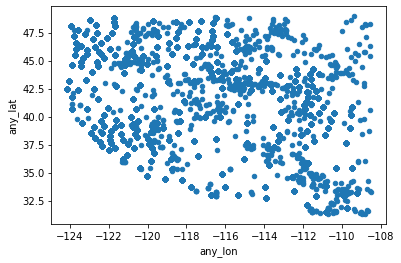

In [15]:
motherload.plot(kind = 'scatter', x='any_lon', y = 'any_lat'); #oof.  try 20?

In [16]:
len(motherload['county_name'].unique())

248

In [68]:
#already standardized (all in decimal degrees)
X = motherload[['any_lon', 'any_lat']]
km = KMeans(n_clusters=32, random_state=42)
km.fit(X)

KMeans(n_clusters=32, random_state=42)

In [69]:
silhouette_score(X, km.labels_)

0.47002997807001584

In [70]:
motherload['cluster'] = km.labels_.astype('object')

In [71]:
centroids = pd.DataFrame(km.cluster_centers_, columns=['any_lon', 'any_lat'])
centroids.head()

,any_lon,any_lat
0,-118.270062,41.438174
1,-115.950378,33.332088
2,-122.708868,45.754374
3,-114.229355,43.058112
4,-121.766189,37.978105


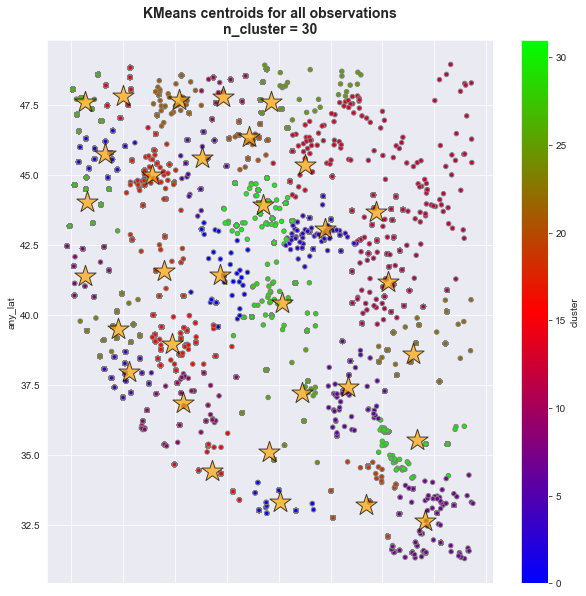

In [72]:
N = 30
# color_labs = motherload['cluster'].unique()
# col_from_palette = sns.color_palette('Dark2', n_clusters)
# cmap = dict(zip(color_labs, col_from_palette))
sns.set_style('darkgrid')
# # define the colormap
cmap = plt.cm.brg
# extract color
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
# above code from https://stackoverflow.com/questions/12487060/matplotlib-color-according-to-class-labels

ax = motherload.plot(kind = 'scatter', x='any_lon', y = 'any_lat', 
                    figsize=(10,10), c = 'cluster', edgecolor='grey', cmap=cmap)

centroids.plot(x='any_lon', y='any_lat', marker='*', c='orange', alpha=.7,
               kind = 'scatter', s=500, edgecolor='black', ax = ax);
plt.title('KMeans centroids for all observations\nn_cluster = 30', size=14, fontweight='bold');

## Check against DBSCAN
## Conclusion: nope.  Use KMeans.
Auto-determined # of clusters would be nice...might be too variable in density though

In [56]:
# X = motherload[['any_lon', 'any_lat']]
# db = DBSCAN(eps=.1, min_samples=5)  # 1 = 1 decimal degrees = 111km = 70mi
# db.fit(X)

DBSCAN(eps=0.1)

In [57]:
# motherload['db_cluster'] = db.labels_.astype('object')

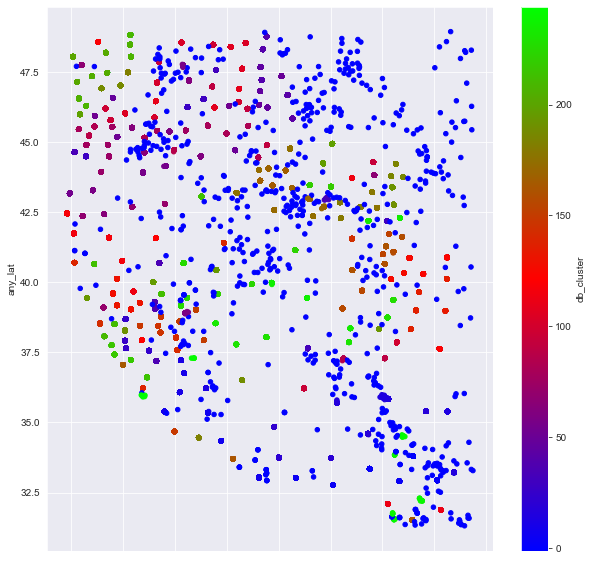

In [61]:
# N = len(motherload.db_cluster.unique())
# sns.set_style('darkgrid')
# cmap = plt.cm.brg
# cmaplist = [cmap(i) for i in range(cmap.N)]
# cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
# # above code from https://stackoverflow.com/questions/12487060/matplotlib-color-according-to-class-labels

# ax = motherload.plot(kind = 'scatter', x='any_lon', y = 'any_lat', 
#                     figsize=(6,6), c = 'db_cluster', cmap=cmap)

In [63]:
# motherload.drop(columns='db_cluster', inplace=True)

## Add fire presence/absence column for each cluster
### 1. for all fires of size class G, from ignition _t_ to _t_+14 days
     Fires > 5000 acres = class G  
     according to National Wildfire Coordinating Group et al.
### 2. for all smaller fires, _t_ to _t_+7 days
When zoomed in to the region I cared about earlier, I would just pull out fire-ignition dates and add 7 days to the yes_fire list.  Now that grouping by cluster, do this for each cluster, then recombine to main df? 

In [74]:
motherload['class_g'] = motherload['burnbndac'].map(lambda x: int(x>=5000))

In [92]:
def yes_fire_col():
    for i in range(len(set(motherload['cluster']))):
        
    
    
    
    
    subset = motherload[['date','event_id','cluster','class_g']].copy()
subset.dropna(inplace=True)
subset.drop_duplicates(inplace=True)  #unique fire events and ignition dates

In [99]:
yes_fire_dates_by_cluster = [] #should be len =n_clusters=32

for i in motherload['cluster']:
    

264     2011-06-26
281     2012-03-16
306     2013-05-13
314     2013-06-16
363     2015-06-17
           ...    
88476   2011-09-13
88477   2014-07-29
88478   2012-07-21
88479   2010-09-14
88480   2015-09-09
Name: date, Length: 1497, dtype: datetime64[ns]

In [76]:
yes_fire = []

for i in subset['date']:
    for j in range(8):
        f = i + timedelta(days=j)
        yes_fire.append(f)

0    87470
1     1011
Name: class_g, dtype: int64

### Southern AZ
AZ has a steady mix of wildfires and rx burns with neighboring AQI stations and smoke estimation.  Model all fire events in Southern AZ (lat<33.4) and the major counties: Pima, Santa Cruz, Maricopa, Cochise.  
Add fire presence/absence column to entire region (neighboring counties), from ignition day t to t+7

In [22]:
south_az = motherload.loc[motherload.state == 'AZ'].copy()
south_az = south_az.loc[south_az.lat_smo < 33.5]

In [23]:
#create column indicating presence of fire from start to t+7
subset = south_az[['date','event_id']].copy()

In [24]:
subset.dropna(inplace=True)
subset.drop_duplicates(inplace=True)

In [25]:
yes_fire = []

for i in subset['date']:
    for j in range(8):
        f = i + timedelta(days=j)
        yes_fire.append(f)

In [26]:
new_col = south_az['date'].map(lambda x: 1 if x in yes_fire else 0)
south_az.insert(4, 'yes_fire', new_col)

In [27]:
south_az.yes_fire.value_counts(normalize=True)

0    0.617406
1    0.382594
Name: yes_fire, dtype: float64

In [28]:
south_az.describe().T

,count,mean,std,min,25%,50%,75%,max
yes_fire,1827.0,0.382594,0.486154,0.000000,0.000000,0.000000,1.000000,1.000000
burnbndac,1827.0,439.409962,7780.458050,0.000000,0.000000,0.000000,0.000000,226079.000000
smoke_score,1827.0,1.937055,1.998324,1.000000,1.000000,1.000000,1.000000,9.000000
no2_max_ppb,983.0,32.218718,14.386517,0.000000,20.000000,33.000000,42.000000,75.000000
o3_max_ppb,983.0,56.325534,11.007211,20.000000,48.000000,57.000000,65.000000,84.000000
so2_max_ppb,983.0,1.486775,1.004302,0.000000,0.800000,1.300000,2.000000,9.000000
co_max_ppm,983.0,0.525169,0.352079,0.100000,0.300000,0.400000,0.687500,2.800000
burnbndlat,50.0,31.975340,0.714660,31.299000,31.569000,31.678000,31.883500,33.496000
burnbndlon,50.0,-110.772420,0.624817,-111.563000,-111.458000,-110.771000,-110.372000,-109.275000
lat_smo,1827.0,32.747184,0.628234,31.525944,32.097273,32.932678,33.348832,33.348832


In [29]:
south_az.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1827 entries, 245 to 70779
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   state          1827 non-null   object        
 1   county_name    1827 non-null   object        
 2   date           1827 non-null   datetime64[ns]
 3   incid_type     1827 non-null   object        
 4   yes_fire       1827 non-null   int64         
 5   burnbndac      1827 non-null   float64       
 6   smoke_score    1827 non-null   float64       
 7   no2_max_ppb    983 non-null    float64       
 8   no2_aqi_label  1827 non-null   object        
 9   o3_max_ppb     983 non-null    float64       
 10  o3_aqi_label   1827 non-null   object        
 11  so2_max_ppb    983 non-null    float64       
 12  so2_aqi_label  1827 non-null   object        
 13  co_max_ppm     983 non-null    float64       
 14  co_aqi_label   1827 non-null   object        
 15  incid_name     50 

In [30]:
south_az.county_name.value_counts()

Maricopa County      688
Pima County          313
Cochise County       196
Yuma County          178
Graham County        133
Pinal County         110
Santa Cruz County    109
Greenlee County      100
Name: county_name, dtype: int64

### Model 0: testing the waters with logreg
  
A) y = overall_aqi: with overall_aqi as target, drop all other aqi features (collinear). (Like entirely collinear: you constructed overall_aqi from individ_aqis.) Could maybe argually add some max_ppbs in later, but still collinear based on feature engineering methodology.
    * edit: this is dumb, overall_aqi is a fake feature you made up by transforming other features. it is not applicable to real world.  
    
B) y = burnbndac: can air quality and smoke measurements convey the size of fire?  (prob not, but) If so, could recommend prescribed burns under certain size?  No, there's no threshold built-in...

In [31]:
ba_south_az = south_az.drop(columns = ['lat_smo', 'lon_smo', 'state', 'county_name',
                                       'event_id', 'incid_name', 'no2_max_ppb', 'o3_max_ppb',
                                       'so2_max_ppb', 'co_max_ppm']).copy()

In [32]:
ba_south_az

,date,incid_type,yes_fire,burnbndac,smoke_score,no2_aqi_label,o3_aqi_label,so2_aqi_label,co_aqi_label,burnbndlat,burnbndlon,no2_aqi_num,o3_aqi_num,so2_aqi_num,co_aqi_num,overall_aqi,any_lat,any_lon,cluster
245,2010-06-04,No_fire,0,0.0,1.0,0,0,0,0,NaN,NaN,0,0,0,0,0,32.932678,-109.887499,19
246,2010-06-06,No_fire,0,0.0,1.0,0,0,0,0,NaN,NaN,0,0,0,0,0,32.932678,-109.887499,19
247,2010-07-13,No_fire,0,0.0,4.0,0,0,0,0,NaN,NaN,0,0,0,0,0,32.932678,-109.887499,19
248,2010-11-02,No_fire,0,0.0,1.0,0,0,0,0,NaN,NaN,0,0,0,0,0,32.932678,-109.887499,19
249,2011-02-11,No_fire,0,0.0,1.0,0,0,0,0,NaN,NaN,0,0,0,0,0,32.932678,-109.887499,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70723,2015-06-19,No_fire,1,0.0,1.0,0,0,0,0,NaN,NaN,0,0,0,0,0,31.525944,-110.846612,19
70725,2015-06-22,No_fire,1,0.0,1.0,0,0,0,0,NaN,NaN,0,0,0,0,0,31.525944,-110.846612,19
70745,2015-08-18,No_fire,0,0.0,1.0,0,0,0,0,NaN,NaN,0,0,0,0,0,31.525944,-110.846612,19
70777,2016-03-10,No_fire,0,0.0,1.0,0,0,0,0,NaN,NaN,0,0,0,0,0,31.525944,-110.846612,19


In [33]:
print(len(ba_south_az))
ba_south_az.isnull().sum()

1827


date                0
incid_type          0
yes_fire            0
burnbndac           0
smoke_score         0
no2_aqi_label       0
o3_aqi_label        0
so2_aqi_label       0
co_aqi_label        0
burnbndlat       1777
burnbndlon       1777
no2_aqi_num         0
o3_aqi_num          0
so2_aqi_num         0
co_aqi_num          0
overall_aqi         0
any_lat             0
any_lon             0
cluster             0
dtype: int64

In [34]:
ba_south_az.drop_duplicates(inplace=True)

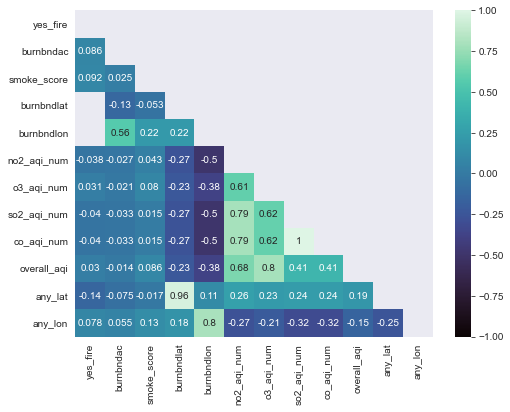

In [35]:
plt.figure(figsize=(8,6))
mask=np.zeros_like(ba_south_az.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(ba_south_az.corr(), cmap='mako', annot=True, mask=mask,
           vmin=-1, vmax=1);

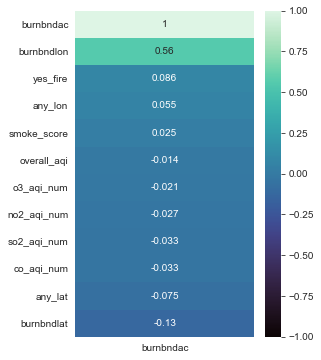

In [36]:
#does not look promising
plt.figure(figsize=(4,6))
az_corr = ba_south_az.corr()[['burnbndac']].sort_values('burnbndac', ascending=False)
sns.heatmap(az_corr, cmap='mako', annot=True, vmin=-1, vmax=1);

In [37]:
ba_south_az.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1068 entries, 245 to 70779
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1068 non-null   datetime64[ns]
 1   incid_type     1068 non-null   object        
 2   yes_fire       1068 non-null   int64         
 3   burnbndac      1068 non-null   float64       
 4   smoke_score    1068 non-null   float64       
 5   no2_aqi_label  1068 non-null   object        
 6   o3_aqi_label   1068 non-null   object        
 7   so2_aqi_label  1068 non-null   object        
 8   co_aqi_label   1068 non-null   object        
 9   burnbndlat     33 non-null     float64       
 10  burnbndlon     33 non-null     float64       
 11  no2_aqi_num    1068 non-null   int64         
 12  o3_aqi_num     1068 non-null   int64         
 13  so2_aqi_num    1068 non-null   int64         
 14  co_aqi_num     1068 non-null   int64         
 15  overall_aqi    106

In [38]:
categoricals = ba_south_az.select_dtypes(include= ['object']).columns
nums = ba_south_az.select_dtypes(exclude = ['object']).columns
all_cats = ba_south_az[categoricals]
all_nums = ba_south_az[nums]

In [39]:
all_cats = pd.get_dummies(all_cats, drop_first = True)

In [40]:
reco = pd.concat([all_cats, all_nums], axis=1)

In [41]:
reco.head(40)

,incid_type_Prescribed Fire,incid_type_Wildfire,no2_aqi_label_good,no2_aqi_label_moderate,o3_aqi_label_good,o3_aqi_label_moderate,o3_aqi_label_unhealthy for at-risk,so2_aqi_label_good,co_aqi_label_good,cluster_19,date,yes_fire,burnbndac,smoke_score,burnbndlat,burnbndlon,no2_aqi_num,o3_aqi_num,so2_aqi_num,co_aqi_num,overall_aqi,any_lat,any_lon
245,0,0,0,0,0,0,0,0,0,1,2010-06-04,0,0.0,1.0,NaN,NaN,0,0,0,0,0,32.932678,-109.887499
246,0,0,0,0,0,0,0,0,0,1,2010-06-06,0,0.0,1.0,NaN,NaN,0,0,0,0,0,32.932678,-109.887499
247,0,0,0,0,0,0,0,0,0,1,2010-07-13,0,0.0,4.0,NaN,NaN,0,0,0,0,0,32.932678,-109.887499
248,0,0,0,0,0,0,0,0,0,1,2010-11-02,0,0.0,1.0,NaN,NaN,0,0,0,0,0,32.932678,-109.887499
249,0,0,0,0,0,0,0,0,0,1,2011-02-11,0,0.0,1.0,NaN,NaN,0,0,0,0,0,32.932678,-109.887499
250,0,0,0,0,0,0,0,0,0,1,2011-03-25,1,0.0,1.0,NaN,NaN,0,0,0,0,0,32.932678,-109.887499
251,0,0,0,0,0,0,0,0,0,1,2011-05-19,0,0.0,4.0,NaN,NaN,0,0,0,0,0,32.932678,-109.887499
252,0,0,0,0,0,0,0,0,0,1,2011-06-02,1,0.0,1.0,NaN,NaN,0,0,0,0,0,32.932678,-109.887499
253,0,0,0,0,0,0,0,0,0,1,2011-06-03,1,0.0,1.0,NaN,NaN,0,0,0,0,0,32.932678,-109.887499
254,0,0,0,0,0,0,0,0,0,1,2011-06-04,1,0.0,1.0,NaN,NaN,0,0,0,0,0,32.932678,-109.887499


In [42]:
X = reco.drop(['burnbndac', 'date'], axis=1)
y = reco['burnbndac']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [43]:
dummy_model = DummyRegressor()
dummy_model.fit(Z_train, y_train)

DummyRegressor()

In [44]:
#rmse with mse & dummy_model.predict
mean_squared_error(y_train, dummy_model.predict(y_train),squared=False), mean_squared_error(y_test, dummy_model.predict(y_test), squared=False)

NameError: name 'mean_squared_error' is not defined